### 1. Your task is to apply k-means to the iris dataset and see what happens when you change the value of k. Which solution, if any, do you find most compelling? Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor. Keep in mind that it's possible you may find a solution with more than 3 clusters that nevertheless better tracks the real, trinary outcome – two of those clusters may map to a single flower type while the other two map to the other types for example.


In [6]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sqlalchemy import create_engine
import warnings
from sklearn import datasets

warnings.filterwarnings('ignore')

In [7]:
# Loading the data from Sklearn's datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [18]:
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=32, random_state=123)

# Fit model
%timeit kmeans_cluster.fit(X_std)
y_pred = kmeans_cluster.predict(X_std)

69.6 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


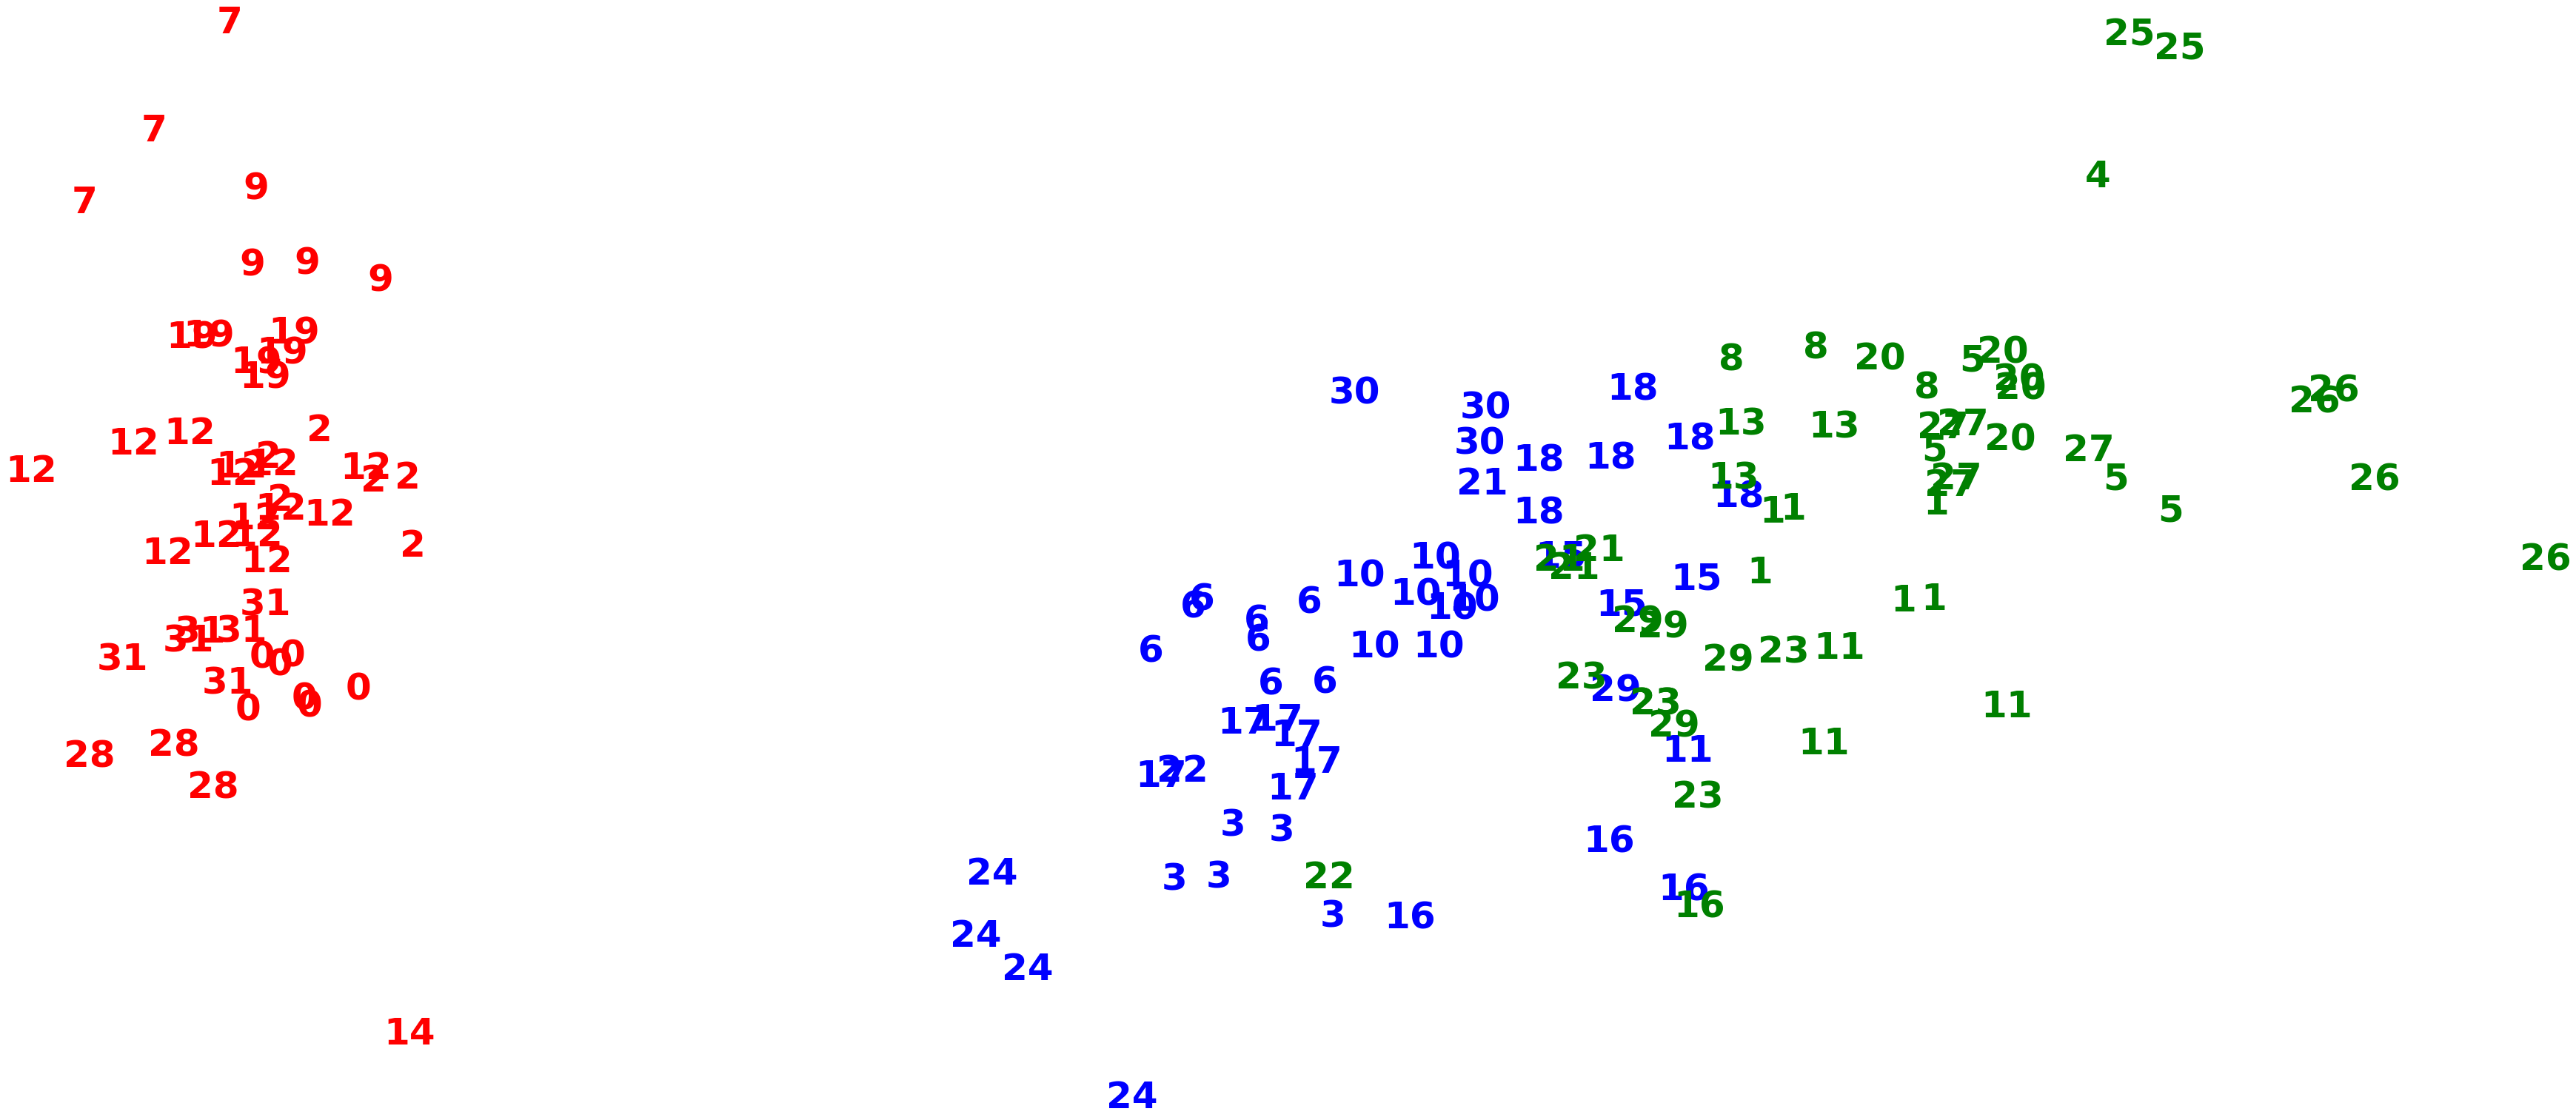

In [19]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(y_pred[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

oddly, increasing the n_clusters produced the most dramatic improvement in predicting types. It does seem that after 12/16 n_clusters the actualized prediction improvement begins to drop off. That being said this produces way more groups the we need and k = 3 is the best solution as it's accurate.

### 2. Create a k-means solution that correctly assigns patients to "heart disease diagnosis" or "no heart disease diagnosis" clusters. Note that in this case, we actually know the correct number of clusters in the data which is two. But, you'll test whether k-means will assign observations as we expect it to do. Since k-means is an unsupervised learning algorithm, it will be blind to whether or not patients have heart disease.

In [20]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

heartdisease_df = pd.read_sql_query('select * from heartdisease',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [21]:
# Define the features and the outcome
X = heartdisease_df.iloc[:, :13]
y = heartdisease_df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y > 0, 0, 1)

In [33]:
#standardizing features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [34]:
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=2, random_state=123)

# Fit model
%timeit kmeans_cluster.fit(X_std)
y_pred = kmeans_cluster.predict(X_std)

15.2 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


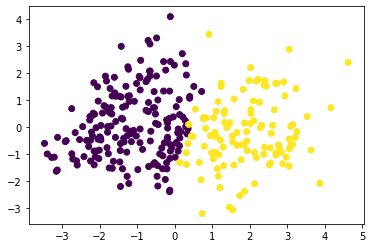

Comparing k-means clusters against the data:
col_0    0    1
row_0          
0       38  151
1      101   13


In [35]:
# Reduce it to two components for visualization
X_pca = PCA(2).fit_transform(X_std)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Seems really accurate